<a href="https://colab.research.google.com/github/whyeon92/6th-Intermediate/blob/Week11/%5BWeek11%5D_Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Batch Normalization in Pytorch

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

#number of subprocesses to use for data loading
num_workers = 0
#how many samples per batch to load
batch_size = 64

#convert data to torch.FloatTensor
transform = transforms.ToTensor()

#get the training and test datasets
train_data = datasets.MNIST(root = 'data', train = True,
                            download = True, transform = transform)

test_data = datasets.MNIST(root = 'data', train = False,
                            download = True, transform = transform)

#prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                           num_workers = num_workers)

### Visualize the data

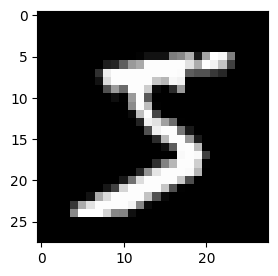

In [8]:
#obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(iter(train_loader))
#기존 코드 에러나서 고쳤어용
#https://dacon.io/forum/407531
#참고 링크, 기존 에러: '_SingleProcessDataLoaderIter' object has no attribute 'next'
images = images.numpy()

#get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = 'gray')

## Neural network classes for testing

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
  def __init__(self, use_batch_norm, input_size = 784, hidden_dim = 256, output_size = 10):
    """
    Creates a PyTorch net using the given parameters.

    :param use_batch_norm: bool
        Pass True to create a network that uses batch normalization; False otherwise
        Note: this network will not use batch normalization on layers that do not have an
        activation function.
    """
    super(NeuralNet, self).__init__() #init super

    #Default layer sizes
    self.input_size = input_size  #(28*28 images)
    self.hidden_dim = hidden_dim
    self.output_size = output_size #(number of classes)
    #Keep track of whether or not this network uses batch normalization
    self.use_batch_norm = use_batch_norm

    #define hidden linear layers, with optional batch norm on their outputs
    # -> use_batch_norm은 불린 값으로 선택 옵션
    #layers with batch_norm applied have no bias term -> bias = False로 설정!
    if use_batch_norm:
      self.fc1 = nn.Linear(input_size, hidden_dim*2, bias = False)
      #배치 정규화 코드 추가
      self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
    else:
      self.fc1 = nn.Linear(input_size, hidden_dim*2)

    #define *second* hidden linear layers, with optional batch norm on their outputs
    #위와 같이 2nd layer 만들기, 근데 이제 배치 정규화 옵션에 따라 다르게 설정.
    if use_batch_norm:
      self.fc2 = nn.Linear(hidden_dim*2, hidden_dim, bias = False)
      #배치 정규화 코드 추가
      self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
    else:
      self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)

    #third and final, fully_connected layer
    self.fc3 = nn.Linear(hidden_dim, output_size)

  def forward(self, x):
    #flatten image 이미지 데이터 flat
    x = x.view(-1, 28*28)
    #all hidden layers + optional batch norm + relu activation
    #위에서 만든 층 정리
    x = self.fc1(x)
    #배치 정규화 여부에 따라 batch_norm 추가 여부 결정
    if self.use_batch_norm:
      x = self.batch_norm1(x)
    x = F.relu(x)
    #second layer
    x = self.fc2(x)
    if self.use_batch_norm:
      x = self.batch_norm2(x)
    x = F.relu(x)
    #third layer, no batch norm or activation
    x = self.fc3(x)
    return x

## Create two different models for testing

In [10]:
#배치 정구화 사용.미사용에 따라 나누어 모델 2개 생성
net_batchnorm = NeuralNet(use_batch_norm = True)
net_no_norm = NeuralNet(use_batch_norm = False)

print(net_batchnorm)
print()
print(net_no_norm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## Training

In [11]:
def train(model, n_epochs = 10):
  #number of epochs to train the model
  n_epochs = n_epochs
  #track losses
  losses = []

  #optimization strategy
  #specify loss function (categorical cross-entropy) 로스 함수 지정!
  criterion = nn.CrossEntropyLoss()

  #specify optimizer (stochastic gradient descent) and learning rate = 0.01
  #stochastic 경사하강법을 학습률 0.01로 설정
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

  #set the model to training mode
  model.train()

  for epoch in range(1, n_epochs + 1):
    #monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    batch_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      #clear the gradients of all optimized variables
      #0으로 그래디언트 초기화
      optimizer.zero_grad()
      #forward pass: compute predicted outputs by passing inputs to the model
      #정방향 패스, 예측값 계산해서 넘김
      output = model(data)
      #calculate the loss, 로스 계산
      loss = criterion(output, target)
      #backward pass: compute gradient of the loss with respect to model parameters
      #역전파 계산
      loss.backward()
      #perform a single optimization step (parameter update)
      #가중치 업데이트!
      optimizer.step()
      #update average training loss
      train_loss += loss.item() #add up avg batch loss
      batch_count += 1

    #print training statistics
    losses.append(train_loss/batch_count)
    print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch, train_loss/batch_count))

  #return all recorded batch losses
  return losses

## Comparing Models

In [12]:
#batchnorm model losses
#this may take some time to train
#배치 정규화 적용 모델 학습
losses_batchnorm = train(net_batchnorm)

Epoch: 1 	 Training Loss: 0.385177
Epoch: 2 	 Training Loss: 0.162520
Epoch: 3 	 Training Loss: 0.112744
Epoch: 4 	 Training Loss: 0.083793
Epoch: 5 	 Training Loss: 0.064182
Epoch: 6 	 Training Loss: 0.049850
Epoch: 7 	 Training Loss: 0.039006
Epoch: 8 	 Training Loss: 0.030671
Epoch: 9 	 Training Loss: 0.024263
Epoch: 10 	 Training Loss: 0.019381


In [13]:
#*no* norm model losses
#you should already start to see a difference in training losses
#배치 정규화 적용 X 모델 학습
losses_no_norm = train(net_no_norm)

Epoch: 1 	 Training Loss: 1.618571
Epoch: 2 	 Training Loss: 0.524135
Epoch: 3 	 Training Loss: 0.382069
Epoch: 4 	 Training Loss: 0.332347
Epoch: 5 	 Training Loss: 0.302206
Epoch: 6 	 Training Loss: 0.279368
Epoch: 7 	 Training Loss: 0.260059
Epoch: 8 	 Training Loss: 0.242935
Epoch: 9 	 Training Loss: 0.227426
Epoch: 10 	 Training Loss: 0.213286


확실히 배치 정규화 넣은 모델이 더 성능이 좋다!!

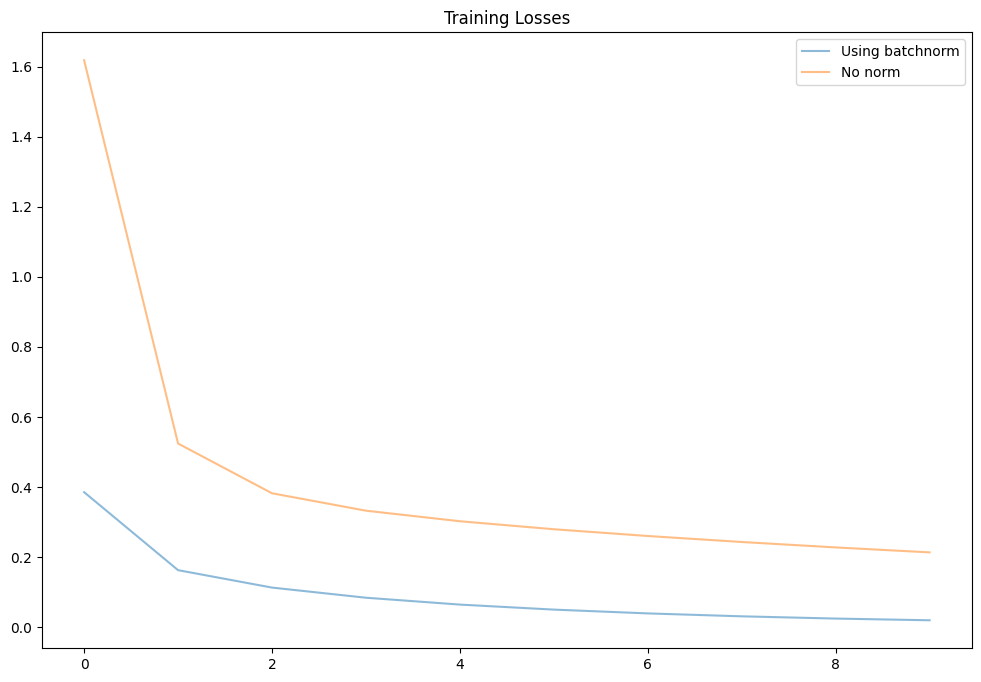

In [14]:
#compare
fig, ax = plt.subplots(figsize = (12, 8))
#근데 이 밑에 있는 코드는 대체 왜 적으신 걸까... 넘파이 어레이로 바꿔야 시각화 가능한가...
#losses_batchnorm = np.array(losses_batchnorm)
#losses_no_norm = np.array(losses_no_norm)
plt.plot(losses_batchnorm, label = 'Using batchnorm', alpha = 0.5)
plt.plot(losses_no_norm, label = 'No norm', alpha = 0.5)
plt.title('Training Losses')
plt.legend()

시각화해서 봐도 배치 정규화한 모델이 훨씬 좋다! 모든 에포크에서!!

## Testing

In [16]:
def test(model, train):
  #initialize vars to monitor test loss and accuracy
  #loss랑 정확도 넣어둘 공간 설정
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  test_loss = 0.0

  #set model to train or evaluation mode
  #just to see the difference in behavior
  #근데 왜 if else안쓰고 if만 두개 쓴거지...???
  if(train == True):
    model.train()
  if(train == False):
    model.eval()

  #loss criterion
  criterion = nn.CrossEntropyLoss()

  for batch_idx, (data, target) in enumerate(test_loader):
    #미니배치 크기 저장
    batch_size = data.size(0)
    #forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    #calculate the loss
    loss = criterion(output, target)
    #update average test loss
    test_loss += loss.item()*batch_size
    #convert output probabilities to predicted class
    #output 확률 값을 예측 클래스 값으로 변환
    #output -> 전자 : 0일 확률, 후자 : 1일 확률 -> 전자가 크면 0이라는 인덱스 반환, 아니면 1이라는 인덱스 반환
    #-> 해당 함수로 확률값을 클래스로 변환 가능... 한 것 같음... 허허
    _, pred = torch.max(output, 1)
    #compare predictions to true label, 차원 맞추기 위해 np.squeeze 사용
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    #calculate test accuracy for each object class
    for i in range(batch_size):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
  print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

  for i in range(10):
    if class_total[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %(
          str(i), 100*class_correct[i] / class_total[i],
          np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' %(classes[i]))

  print('\n Test Accuracy (Overall): %2d%% (%2d/%2d)' %(
      100.*np.sum(class_correct)/np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

## Training and Evaluation Mode

배치 정규화 사용 모델 적용  
-> **Training mode** means that the batch normalization layers will use batch statistics to calculate the batch norm.  
 기존에 있는 배치에 대한 평균, 분산을 사용  
-> **Evaluation mode**, on the other hand, uses the estimated population mean and variance from the entire training set, which should give us increased performance on this test data!  
전체 학습 데이터로부터 추정된 모평균과 모분산 값을 사용 -> 성능 향상 가능!  

In [17]:
#test batchnorm case, in *train* mode
test(net_batchnorm, train = True)

Test Loss: 0.081082

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 96% (997/1032)
Test Accuracy of     3: 97% (988/1010)
Test Accuracy of     4: 97% (957/982)
Test Accuracy of     5: 96% (864/892)
Test Accuracy of     6: 97% (932/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 96% (943/974)
Test Accuracy of     9: 96% (976/1009)

 Test Accuracy (Overall): 97% (9761/10000)


In [18]:
#test batchnorm case, in *evaluation* mode
test(net_batchnorm, train = False)

Test Loss: 0.069655

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 97% (1007/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 97% (959/982)
Test Accuracy of     5: 97% (872/892)
Test Accuracy of     6: 97% (934/958)
Test Accuracy of     7: 96% (997/1028)
Test Accuracy of     8: 96% (937/974)
Test Accuracy of     9: 98% (990/1009)

 Test Accuracy (Overall): 97% (9786/10000)


In [19]:
#for posterity, test no norm case in eval mode
test(net_no_norm, train = False)

Test Loss: 0.204612

Test Accuracy of     0: 98% (965/980)
Test Accuracy of     1: 98% (1114/1135)
Test Accuracy of     2: 91% (943/1032)
Test Accuracy of     3: 93% (941/1010)
Test Accuracy of     4: 93% (914/982)
Test Accuracy of     5: 93% (832/892)
Test Accuracy of     6: 95% (913/958)
Test Accuracy of     7: 92% (954/1028)
Test Accuracy of     8: 91% (889/974)
Test Accuracy of     9: 93% (940/1009)

 Test Accuracy (Overall): 94% (9405/10000)


배치 정규화 모델이 배치 정규화를 사용하지 않은 모델보다 성능이 좋고,  
배치 정규화 모델 중에서도 eval 모델이 더 좋다!